In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import tensorflow as tf
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        
        # Weights and biases initialization
        self.weights = tf.Variable(tf.random.normal([n_visible, n_hidden], stddev=0.01))
        self.hidden_bias = tf.Variable(tf.zeros([n_hidden]))
        self.visible_bias = tf.Variable(tf.zeros([n_visible]))
        
    def sample_h(self, v):
        """Sample from the hidden layer"""
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.weights) + self.hidden_bias)
        return tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob))))

    def sample_v(self, h):
        """Sample from the visible layer"""
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.weights)) + self.visible_bias)
        return tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))

    def train(self, v_data, epochs=1000):
        for epoch in range(epochs):
            h_data = self.sample_h(v_data)
            v_data_reconstructed = self.sample_v(h_data)
            
            # Update weights and biases
            positive_grad = tf.matmul(tf.transpose(v_data), h_data)
            negative_grad = tf.matmul(tf.transpose(v_data_reconstructed), self.sample_h(v_data_reconstructed))

            self.weights.assign_add(self.learning_rate * (positive_grad - negative_grad) / tf.cast(tf.shape(v_data)[0], tf.float32))
            self.visible_bias.assign_add(self.learning_rate * tf.reduce_mean(v_data - v_data_reconstructed, axis=0))
            self.hidden_bias.assign_add(self.learning_rate * tf.reduce_mean(h_data - self.sample_h(v_data_reconstructed), axis=0))


In [3]:
# Load and preprocess the dataset
iris = load_iris()
X = iris.data
y = iris.target

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [4]:
# Create and train the RBM
n_visible = X.shape[1]
n_hidden = 5  # Number of hidden units in the RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden)
rbm.train(tf.convert_to_tensor(X_train, dtype=tf.float32), epochs=1000)

In [5]:
# Define the feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(n_visible,)),  # First hidden layer
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer (3 classes for iris)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the original dataset for simplicity
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
4/4 [==============================] - 1s 10ms/step - loss: 1.0263 - accuracy: 0.4583
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 1.0018 - accuracy: 0.4667
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 0.9780 - accuracy: 0.4750
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.9551 - accuracy: 0.4917
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.9329 - accuracy: 0.5333
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.9124 - accuracy: 0.5583
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8916 - accuracy: 0.5750
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8739 - accuracy: 0.6083
Epoch 9/50
4/4 [==============================] - 0s 2ms/step - loss: 0.8535 - accuracy: 0.6333
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8361 - accuracy: 0.6417
Epoch 11/50
4/4 [=====================

# Evaluate the Model

In [6]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Model Accuracy: {accuracy:.2f}")

1/1 [==============================] - 0s 145ms/step
Model Accuracy: 0.93


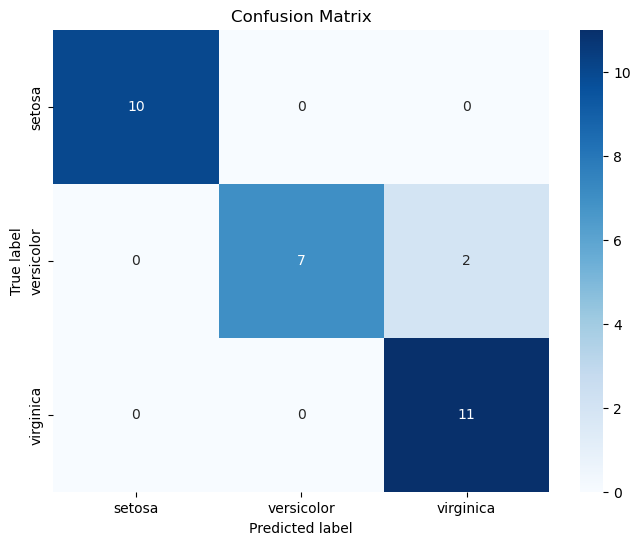

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
from sklearn.metrics import classification_report

# Print classification report
report = classification_report(y_test, y_pred_classes, target_names=iris.target_names)
print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.78      0.88         9
   virginica       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



1/1 [==============================] - 0s 30ms/step


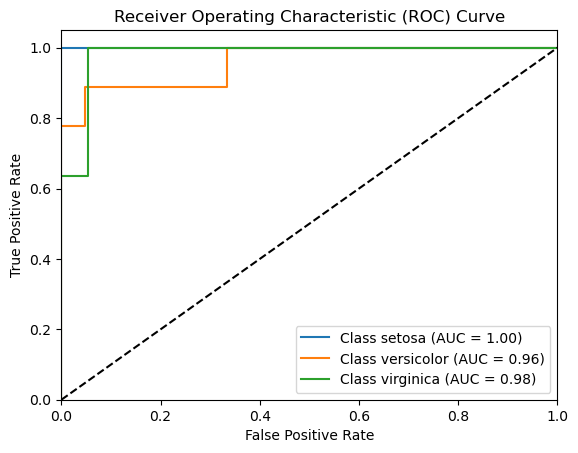

In [9]:
from sklearn.metrics import roc_curve, auc

# Binarize the output for multi-class ROC
y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC for each class
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {iris.target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Logistic Regression as a simple model for demonstration
logistic_model = LogisticRegression(max_iter=200)
cross_val_scores = cross_val_score(logistic_model, X_scaled, y, cv=5)  # 5-fold cross-validation
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean():.2f}")

Cross-Validation Scores: [0.96666667 1.         0.93333333 0.9        1.        ]
Mean Cross-Validation Score: 0.96
